In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.constants import physical_constants
from scipy import stats
import scipy.special as sps

import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
F = physical_constants['Faraday constant'][0]
R = physical_constants['molar gas constant'][0]

T = 298.15
rho_0 = 4.87 #NCM density g/cm^3 (fully lithiated!)
D = 10**-10
c = 0.05 #Lithium concentration in mol/cm^3
W = 20

mass = 0.010 #mass of NCM in the cathode


def Z_w_no_area(c,W,D):
    return (R*T/(F**2)*1/c*(W/(np.sqrt(D))))

#I like this color
main_c = (0,0,0.7,0.75)

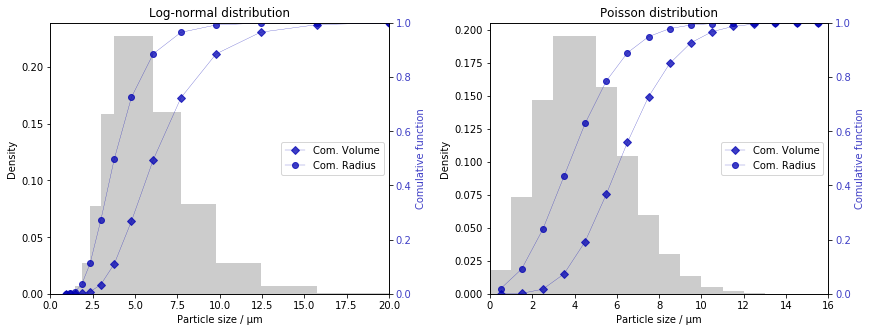

In [3]:
def r_binomial(n):
    f = np.array([sps.comb(n-1, i, exact=True) for i in range(n)], dtype='O')
    f = np.float64(f)/(np.float64(f).sum())
    if not np.allclose(f.sum(), 1.0):
        raise ValueError("The distribution is not properly normalized. Density sum = %".format(f.sum()))
        
    return f

def get_norm_dist(n_bins, radii):
    if n_bins > 1:
        bin_size = (radii[1]-radii[0])/n_bins
        p_sizes = [(radii[0]+(i*bin_size+bin_size/2)) for i in range(n_bins)]

        #generates the distribution of radii
        dist_NCM_r = np.array([i for i in r_binomial(n_bins)])
        p_volumes = np.array([i**3 for i in p_sizes])

        #normalize the volume distribution
        dist_NCM_vol = np.array([i*k for i,k in zip(dist_NCM_r,p_volumes)])
        volume_sum = dist_NCM_vol.sum()
        dist_NCM_vol = np.array([i/volume_sum for i in dist_NCM_vol])
        return (p_sizes,dist_NCM_r,dist_NCM_vol)
    else:
        return (radii[1]/2,1,1)

def get_poisson_dist(mu,n_bins):
    if n_bins > 1:
        dist = [stats.poisson.pmf(i, mu, loc=0) for i in range(n_bins)]
        p_sizes = [(0.5+i) for i in range(n_bins)]
        p_volumes = np.array([i**3 for i in p_sizes])

        #normalize the volume distribution
        dist_NCM_vol = np.array([i*k for i,k in zip(dist,p_volumes)])
        volume_sum = dist_NCM_vol.sum()
        dist_NCM_vol = np.array([i/volume_sum for i in dist_NCM_vol])
        return (p_sizes,dist,dist_NCM_vol)
    else:
        return (mu,1,1)
    
def get_lognorm_dist(mean,sigma,p_range,n_bins, d_cut=10**-4):
    if n_bins > 1:
        p_sizes_0 = np.array([i for i in np.logspace(np.log10(p_range[0]),np.log10(p_range[1]),n_bins)])
        dist_0 = np.array([stats.lognorm.pdf(i, s=sigma, scale=mean) for i in p_sizes_0])

        #normalize the radius distribution
        radius_sum = np.array(dist_0).sum()
        dist_r = np.array([i/radius_sum for i in dist_0])
        
        # cutting  off very low density values, otherwise total volume will be given by few large paricles 
        dist = []
        p_siz = []
        for i in zip(p_sizes_0, dist_r):
            if i[1] > d_cut:
                dist.append(i[1])
                p_siz.append(i[0])
        
        #normalize the volume distribution
        p_volumes = np.array([i**3 for i in p_siz])
        dist_NCM_vol = np.array([i*k for i,k in zip(dist,p_volumes)])
        volume_sum = dist_NCM_vol.sum()
        
        dist_NCM_vol = np.array([i/volume_sum for i in dist_NCM_vol])
        return (np.array(p_siz),np.array(dist),dist_NCM_vol)
    else:
        return (mu,1,1)

    
#generates data for the binomial distribution    
mean = 5
sigma = 0.4
n_bins = 30
p_range = [0.02,20]
p_sizes,dist_NCM_r,dist_NCM_vol = get_lognorm_dist(mean, sigma,p_range, n_bins)


# plotting jargon
fig, (ax, ax3) = plt.subplots(1, 2, figsize=(12, 4.5),constrained_layout=True, num='seaborn-notebook')
ax.bar(p_sizes[:-1], dist_NCM_r[:-1], label='Radius Distr.', width=np.diff(p_sizes), align='edge', color=(0,0,0,0.2))
ax.set_ylabel('Density')
ax.set_xlabel('Particle size / µm')
ax2 = ax.twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax2.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.set_xlim(0,p_range[1])
ax2.legend(loc='center right')
plt.title('Log-normal distribution')

#generates data for the poisson distribution
mean_size = 4
n_bins = 16
p_sizes,dist_NCM_r,dist_NCM_vol = get_poisson_dist(mean_size, n_bins)

#plotting jargon
ax3.bar(p_sizes, dist_NCM_r, label='Radius Distr.', width=1, align='center', color=(0,0,0,0.2))
ax3.set_ylabel('Density')
ax3.set_xlabel('Particle size / µm')
ax3.set_xlim((0,n_bins))
ax4 = ax3.twinx()
ax4.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax4.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax4.set_ylabel('Comulative function', color = main_c)
ax4.tick_params(axis='y', labelcolor= main_c)
ax4.set_ylim(0,1)
ax4.set_xlim(0,n_bins)
ax4.legend(loc='center right')
plt.title('Poisson distribution')
plt.show()

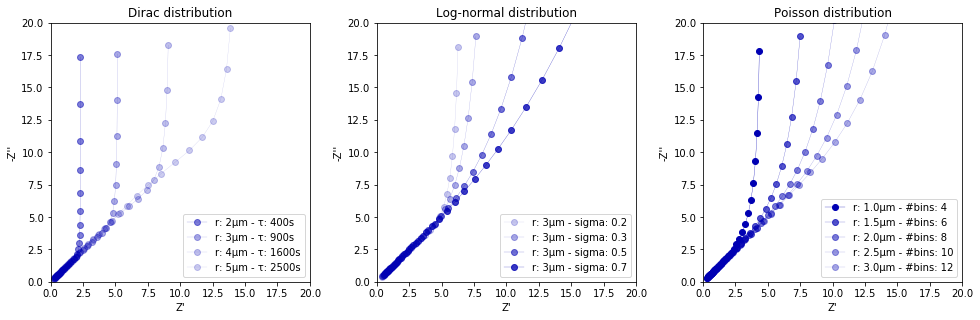

In [4]:
#define the frequency range from 1 Hz to 0.001 Hz, 30 points in totalin logaritmic space
f_range = np.logspace(0,-3,30)

#single frequency response of a 'Warbug-open' element
def w_open(freq, Z_w, tau):
    return (Z_w/(np.sqrt(1j*freq))*(1/np.tanh(np.sqrt(1j*freq*tau))))

#calculates the impedance in the given frequncy range 
def z_warburg_o(radius, fraction, f_range, c, W, D):
    #define partile surface area and volume
    p_area = 4*np.pi*(radius/10**4)**2
    p_volume = 4/3*np.pi*(radius/10**4)**3
    
    # number of particles given their fration in the mass of cathode
    n_particles = (mass/rho_0)*fraction*(1/p_volume)
    
    #calculates the Warburg diffusion resistance and characteristic time
    Z_w = Z_w_no_area(c, W, D) / (p_area * n_particles)
    tau = (radius/10**4)**2/D
    
    #generates the impedance spectra
    Z = np.array([w_open(f, Z_w, tau) for f in f_range])
    return (Z,tau)

def paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, D):
        list_Imp = []
        for size, fraction in zip(p_sizes,dist_NCM_vol):
            if size != 0 and fraction !=0:
                Imp, tau = z_warburg_o(size,fraction,f_range, c, W, D)
                list_Imp.append(Imp)
        Z_dist = stats.hmean(list_Imp, axis=0)/len(list_Imp)
        return Z_dist
    


# initial set of particle sizes, number of bins
set_1 = [2,3,4,5]
set_2 = [0.2,0.3,0.5,0.7]
set_3 = [1,1.5,2,2.5,3]
        
# create the figure
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5),constrained_layout=True, num='seaborn-notebook')

# uses the radius in set_1 to calculate the impedance and plot in the first graph
for i in set_1:
    Imp, tau = z_warburg_o(i,1,f_range, c, W, D)
    axes[0].plot(np.real(Imp), -np.imag(Imp) , label='r: {}µm - τ: {:.0f}s'.format(i, tau), linewidth=0.3, marker='o', color=(0,0,0.7,1/i))
    axes[0].set_title("Dirac distribution")
    
# uses the bin sizes in set_2 to calculate the distribution, then the impedance and plot in the second graph
for i in set_2:
    mean = 3
    p_sizes,dist_NCM_r,dist_NCM_vol = get_lognorm_dist(3,i, p_range, 30)
    if len(p_sizes) > 1:
        Z_dist = paral_imp(p_sizes,dist_NCM_vol,f_range,c, W, D)
    else:
        Z_dist, tau = z_warburg_o(p_sizes,dist_NCM_vol,f_range, c, W, D)       
    axes[1].plot(np.real(Z_dist), -np.imag(Z_dist) , label='r: {:.0f}µm - sigma: {:.1f}'.format(mean, i), linewidth=0.3, marker='o', color=(0,0,0.7,1.1*i))
    axes[1].set_title('Log-normal distribution')

    # uses the bin sizes in set_2 to calculate the distribution, then the impedance and plot in the second graph
for i in set_3:
    p_sizes,dist_NCM_r,dist_NCM_vol = get_poisson_dist(i, int(4*i))
    Z_dist = np.zeros(30)
    if type(p_sizes) == list:
        Z_dist = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, D)
    else:
        Z_dist, tau = z_warburg_o(p_sizes,dist_NCM_vol,f_range, c, W, D)       
    axes[2].plot(np.real(Z_dist), -np.imag(Z_dist) , label='r: {:.1f}µm - #bins: {:.0f}'.format(i, int(4*i)), linewidth=0.3, marker='o', color=(0,0,0.7,1/i))
    axes[2].set_title("Poisson distribution")
    
#prettify the plots
for ax in axes:
    ax.set_ylabel("-Z''")
    ax.set_xlabel("Z'")
    ax.set_aspect(aspect='equal')
    ax.legend(loc='lower right')
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

C:\Users\EnricoTrevisanello\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in tanh
  


`xtol` termination condition is satisfied.
Function evaluations 51, initial cost 3.3151e+01, final cost 1.1524e+00, first-order optimality 2.32e+08.


`xtol` termination condition is satisfied.
Function evaluations 47, initial cost 1.7173e+01, final cost 5.3490e-01, first-order optimality 4.19e+07.

Solutions: 
Fit: [6.49561183 3.27643856] 
Fit with D: [6.01873205 2.74846595 2.34233636]


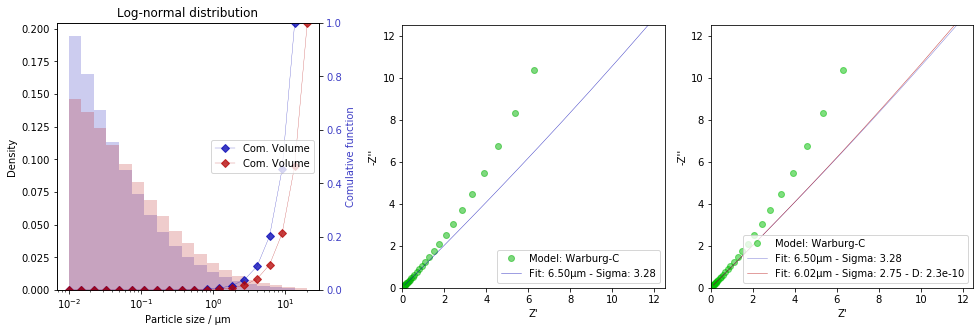

In [5]:
def warburg(freq, Z_w):
    return Z_w/np.sqrt(freq)*(1+1/1j)

def capacitor(freq, C):
    return 1/(1j*freq*C)

def series_imp(Z_list, f_r):
    Z_total = np.zeros(len(f_r))
    for Z_imp in Z_list:
        Z_total = np.add(Z_total, Z_imp)
    return Z_total
        
def warburg_c(Z_w, C, f_r):
    Z_c = np.array([capacitor(f, C) for f in f_r])
    Z_war = np.array([warburg(f, Z_w) for f in f_r])
    Z_total = series_imp([Z_war, Z_c], f_r)
    return Z_total

def fit_weight(Z_m, Z_d, string=None):
    Z_res = (Z_m - Z_d)    
    if string == 'modulus':
        weight = np.absolute(Z_d)
        return np.ravel([Z_res.real/weight, Z_res.imag/weight])    
    elif string == 'proportional':
        return np.ravel([Z_res.real/Z_d.real, Z_res.imag/Z_d.imag])    
    else:
        return np.ravel([Z_res.real, Z_res.imag])

def Z_residuals_magnitude(par_dist, Z_meas, f_r):
    #print(par_dist)
    szs,dist_r,dist_vol = get_lognorm_dist(par_dist[0], par_dist[1], p_limits,n_bins, density_cutoff)
    Z_dist = paral_imp(szs,dist_vol,f_r, c, W, D)
    return  fit_weight(Z_meas, Z_dist, 'proportional')

def Z_residuals_magnitude_wt_D(par_dist, Z_meas, f_r):
    #print(par_dist)
    szs,dist_r,dist_vol = get_lognorm_dist(par_dist[0], par_dist[1], p_limits, n_bins, density_cutoff)
    Z_dist = paral_imp(szs,dist_vol,f_r, c, W, par_dist[2]*10**-10)
    return fit_weight(Z_meas, Z_dist, 'modulus')



# set here the parameters from impedance
Z_w = 0.8
C = 15
f_range = 2*np.pi*np.logspace(1, -3, 30)

T = 298.15
rho_0 = 4.77 #NCM density g/cm^3 (fully lithiated!)
D = 10**-10
c = 0.05 #Lithium concentration in mol/cm^3
W = 20

p_limits = [0.01,20]
n_bins = 20
density_cutoff = 10**-3

mass = 0.010 #mass of NCM in the cathode

Z_W_C = warburg_c(Z_w, C, f_range)



par_dist_0 = np.array([3,4])  # initial guess: mean, sigma for log-norm distribution

solution = least_squares(Z_residuals_magnitude, par_dist_0, bounds = [(0.05,0.2),(10,10)],
                         args=(Z_W_C, f_range ), xtol = 10**-14, ftol=None, verbose=1)

print('\n')

par_dist_1 = np.array([par_dist_0[0],par_dist_0[1], 1])  # initial guess: mean, sigma for log-norm distribution
#par_dist_1 = np.array([solution.x[0],solution.x[1], D/10**-10])  # initial guess: mean, sigma for log-norm distribution

solution_wt_D = least_squares(Z_residuals_magnitude_wt_D, par_dist_1, bounds = [(0.05,0.2,10**-4),(10,10,10**2)],
                         args=(Z_W_C, f_range ), xtol = 10**-14, ftol=None, x_scale='jac', max_nfev=50, verbose=1)


print('\nSolutions:','\nFit:', solution.x, '\nFit with D:',solution_wt_D.x)

#data for plots
p_sizes_fit,dist_NCM_r_fit,dist_NCM_vol_fit = get_lognorm_dist(solution.x[0], solution.x[1],[0.01,20], 20, density_cutoff )
p_sizes_fit_wt_D,dist_NCM_r_fit_wt_D,dist_NCM_vol_fit_wt_D = get_lognorm_dist(solution_wt_D.x[0], solution_wt_D.x[1],[0.01,20], 20, density_cutoff )

Z_fit = paral_imp(p_sizes_fit,dist_NCM_vol_fit,f_range, c, W, D)
Z_fit_wt_D = paral_imp(p_sizes_fit_wt_D,dist_NCM_vol_fit_wt_D,f_range, c, W, solution_wt_D.x[2]*10**-10)

# plotting jargon
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes_fit[:-1], dist_NCM_r_fit[:-1], label='Radius Hist.', width=np.diff(p_sizes_fit), align='edge', color=(0,0,0.7,0.2))
axes[0].bar(p_sizes_fit_wt_D[:-1], dist_NCM_r_fit_wt_D[:-1], label='Radius Hist.', width=np.diff(p_sizes_fit_wt_D), align='edge', color=(0.7,0,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')
axes[0].set_xscale('log')
#axes[0].set_xlim(p_limits[0]/2,p_limits[0]*2)
ax2 = axes[0].twinx()
ax2.plot(p_sizes_fit, np.cumsum(dist_NCM_vol_fit), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
#ax2.plot(p_sizes_fit, np.cumsum(dist_NCM_r_fit), label='Com. Volume', color=main_c, linewidth=0.3, marker='o')
ax2.plot(p_sizes_fit_wt_D, np.cumsum(dist_NCM_vol_fit_wt_D), label='Com. Volume', color=(0.7,0,0,0.75), linewidth=0.3, marker='D')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.legend(loc='center right')
plt.title('Log-normal distribution')


axes[1].plot(np.real(Z_W_C), -np.imag(Z_W_C) , label='Model: Warburg-C', marker='o', linewidth=0, color=(0,0.7,0,0.5))
axes[1].plot(np.real(Z_fit), -np.imag(Z_fit) , label='Fit: {:.2f}µm - Sigma: {:.2f}'.format(solution.x[0],solution.x[1]), linewidth=0.5, color=(0,0,0.7,0.75))

max_axes = max((np.real(Z_W_C).max()+0.25), (np.real(Z_fit).max()+0.25), (np.real(Z_fit_wt_D).max()+0.25) )

axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, max_axes)
axes[1].set_xlim(0,max_axes)

axes[2].plot(np.real(Z_W_C), -np.imag(Z_W_C) , label='Model: Warburg-C', marker='o', linewidth=0, color=(0,0.75,0,0.5))
axes[2].plot(np.real(Z_fit), -np.imag(Z_fit) , label='Fit: {:.2f}µm - Sigma: {:.2f}'.format(solution.x[0],solution.x[1]), linewidth=0.5, color=(0,0,0.7,0.5))
axes[2].plot(np.real(Z_fit_wt_D), -np.imag(Z_fit_wt_D) , label='Fit: {:.2f}µm - Sigma: {:.2f} - D: {:.1e}'.format(solution_wt_D.x[0],solution_wt_D.x[1],solution_wt_D.x[2]*10**-10), linewidth=0.5, color=(0.7,0,0,0.75))

axes[2].set_ylabel("-Z''")
axes[2].set_xlabel("Z'")
axes[2].set_aspect(aspect='equal')
axes[2].legend(loc='lower right')
axes[2].set_ylim(0,max_axes)
axes[2].set_xlim(0,max_axes)

plt.show()

C:\Users\EnricoTrevisanello\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in tanh
  


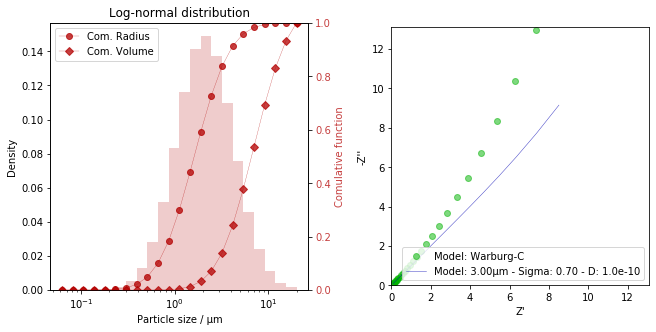

In [6]:
def series_imp(Z_list, f_r):
    Z_total = np.zeros(len(f_r))
    for Z_imp in Z_list:
        Z_total = np.add(Z_total, Z_imp)
    return Z_total
        
def warburg_c(Z_w, C, f_r):
    Z_c = np.array([capacitor(f, C) for f in f_r])
    Z_war = np.array([warburg(f, Z_w) for f in f_r])
    Z_total = series_imp([Z_war, Z_c], f_r)
    return Z_total

# set here the parameters from impedance
Z_w = 0.8
C = 15
f_range = 2*np.pi*np.logspace(1, -3, 30)

T = 298.15
rho_0 = 4.77 #NCM density g/cm^3 (fully lithiated!)

D = 10**-10
c = 0.05 #Lithium concentration in mol/cm^3
W = 20

p_limits = [0.01,20]
mean_size = 3
sigma_dist = 0.7
n_bins = 30
density_cutoff = 10**-6

mass = 0.010 #mass of NCM in the cathode

Z_W_C = warburg_c(Z_w, C, f_range)

solution_wt_D = (mean_size, sigma_dist, D )


#data for plots
p_sizes_fit_wt_D,dist_NCM_r_fit_wt_D,dist_NCM_vol_fit_wt_D = get_lognorm_dist(solution_wt_D[0], solution_wt_D[1],p_limits,n_bins, density_cutoff )


Z_fit_wt_D = paral_imp(p_sizes_fit_wt_D,dist_NCM_vol_fit_wt_D,f_range, c, W, solution_wt_D[2])


# plotting jargon
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes_fit_wt_D[:-1], dist_NCM_r_fit_wt_D[:-1], label='Radius Hist.', width=np.diff(p_sizes_fit_wt_D), align='edge', color=(0.7,0,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')
axes[0].set_xscale('log')
#axes[0].set_xlim(p_limits[0]/2,p_limits[0]*2)
ax2 = axes[0].twinx()
ax2.plot(p_sizes_fit_wt_D, np.cumsum(dist_NCM_r_fit_wt_D), label='Com. Radius', color=(0.7,0,0,0.75), linewidth=0.3, marker='o')
ax2.plot(p_sizes_fit_wt_D, np.cumsum(dist_NCM_vol_fit_wt_D), label='Com. Volume', color=(0.7,0,0,0.75), linewidth=0.3, marker='D')
ax2.set_ylabel('Comulative function', color = (0.7,0,0,0.75))
ax2.tick_params(axis='y', labelcolor= (0.7,0,0,0.75))
ax2.set_ylim(0,1)
ax2.legend(loc='upper left')
plt.title('Log-normal distribution')


axes[1].plot(np.real(Z_W_C), -np.imag(Z_W_C) , label='Model: Warburg-C', marker='o', linewidth=0, color=(0,0.7,0,0.5))
axes[1].plot(np.real(Z_fit_wt_D), -np.imag(Z_fit_wt_D) , label='Model: {:.2f}µm - Sigma: {:.2f} - D: {:.1e}'.format(solution_wt_D[0],solution_wt_D[1], solution_wt_D[2]), linewidth=0.5, color=(0,0,0.7,0.75))

max_axes = max((np.real(Z_W_C).max()+3), (np.real(Z_fit_wt_D).max()+3) )

axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, max_axes)
axes[1].set_xlim(0,max_axes)


plt.show()




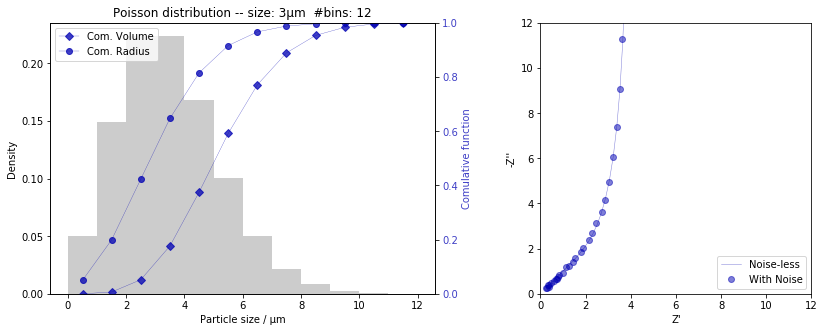

In [7]:
#Here I generated a binomial distribution of particle sizes
mean = 3
n_bins = int(4*mean)
p_sizes,dist_NCM_r,dist_NCM_vol = get_poisson_dist(mean, n_bins)

# and now calculate its impedance
f_range = np.logspace(0,-3,30)
Diff_model = 5*10**-10
Z_model = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, Diff_model)

# this generates complex white noise, normally distribiuted, to be added to simulate a measurment
Z_noise = 0.04*np.random.randn(30, 2).view(np.complex128)[...,0]
Z_meas = np.add(Z_model, Z_noise)

# plotting jargon
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes, dist_NCM_r, label='Radius Distr.', width=1, align='center', color=(0,0,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')
ax2 = axes[0].twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax2.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.legend()
plt.title('Poisson distribution -- size: {:.0f}µm  #bins: {}'.format(mean,n_bins))

axes[1].plot(np.real(Z_model), -np.imag(Z_model) , label='Noise-less', linewidth=0.5, color=(0,0,0.7,0.5))
axes[1].plot(np.real(Z_meas), -np.imag(Z_meas) , label='With Noise', linewidth=0, marker='o', color=(0,0,0.7,0.5))
axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0,12)
axes[1].set_xlim(0,12)

plt.show()

`xtol` termination condition is satisfied.
Function evaluations 21, initial cost 3.5584e+02, final cost 7.8501e-02, first-order optimality 3.16e-08.




C:\Users\EnricoTrevisanello\Miniconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:115: UserWarning: Setting `xtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  .format(name, EPS))


`ftol` termination condition is satisfied.
Function evaluations 43, initial cost 1.9014e+03, final cost 7.7759e-02, first-order optimality 1.81e-01.

Solutions: 
Fit: [4.3314395  0.33710767] 
Fit with D: [4.44340395 0.33842992 5.27380766]


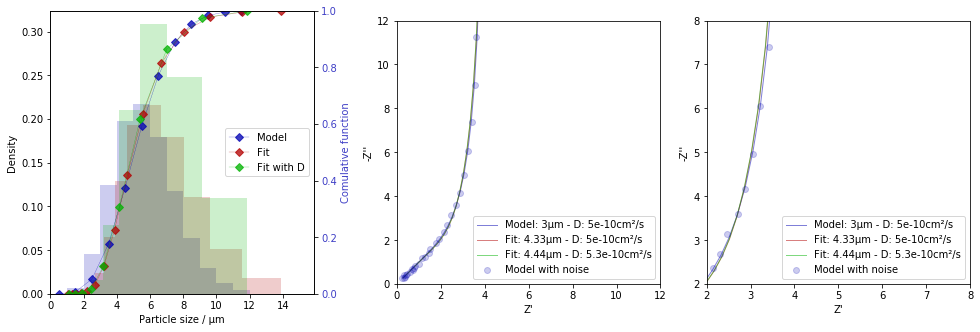

In [8]:
# here I define the residual function that the least_squares method minimize. 

def Z_residuals_magnitude(par_dist, Z_meas, f_range):
    szs,dist_r,dist_vol = get_lognorm_dist(par_dist[0], par_dist[1], [0.01,20],30)
    Z_dist = paral_imp(szs,dist_vol,f_range, c, W, D)
    Z_diff = Z_meas - Z_dist
    return np.ravel([Z_diff.real, Z_diff.imag])

def Z_residuals_magnitude_wt_D(par_dist, Z_meas, f_range):
    #print(par_dist)
    szs,dist_r,dist_vol = get_lognorm_dist(par_dist[0], par_dist[1], [0.01,20],30)
    Z_dist = paral_imp(szs,dist_vol,f_range, c, W, par_dist[2]*10**-10)
    Z_diff = Z_meas - Z_dist
    return np.ravel([Z_diff.real, Z_diff.imag])

D = 5*10**-10

par_dist_0 = np.array([6,0.8])  # initial guess

solution = least_squares(Z_residuals_magnitude, par_dist_0, bounds = [(0.1,0.1),(10,3)], args=(Z_meas, f_range),
                         xtol = 10**-15, ftol=None, verbose=1)
print('\n')

#inital guesses for the second fit with D
#par_dist_1 = np.array([par_dist_0[0]*(2*np.random.ranf(1)),par_dist_0[1], D*np.random.ranf(1)])  # with realistic and randomized values
par_dist_1 = np.array([solution.x[0]+(np.random.ranf(1)-0.5),solution.x[1], np.random.ranf(1)])  # with ditribution parameters obtained from the first fit

solution_wt_D = least_squares(Z_residuals_magnitude_wt_D, par_dist_1, bounds = [(0.1,0.2,10**-4),(10,2,10**2)],
                         args=(Z_meas, f_range ), xtol = 10**-16, x_scale='jac', verbose=1)

print('\nSolutions:','\nFit:', solution.x, '\nFit with D:',solution_wt_D.x)


#data for plots
p_sizes_fit,dist_NCM_r_fit,dist_NCM_vol_fit = get_lognorm_dist(solution.x[0], solution.x[1], [0.1, 20],30)
p_sizes_fit_wt_D,dist_NCM_r_fit_wt_D,dist_NCM_vol_fit_wt_D = get_lognorm_dist(solution_wt_D.x[0], solution_wt_D.x[1],[0.01,20] ,30)


Z_model = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, D)
Z_fit = paral_imp(p_sizes_fit,dist_NCM_vol_fit,f_range, c, W, D)
Z_fit_wt_D = paral_imp(p_sizes_fit_wt_D,dist_NCM_vol_fit_wt_D,f_range, c, W, solution_wt_D.x[2]*10**-10)


# plotting jargon
line_width = 1
dots_opacity = 0.2

fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes, dist_NCM_vol, label='Model dist.', width=1, align='center', color=(0,0,0.7,0.2))
axes[0].bar(p_sizes_fit[:-1], dist_NCM_vol_fit[:-1], label='Fit dist.', width = np.diff(p_sizes_fit), align='edge', color=(0.7,0,0,0.2))
axes[0].bar(p_sizes_fit_wt_D[:-1], dist_NCM_vol_fit_wt_D[:-1], label='Fit dist.', width = np.diff(p_sizes_fit_wt_D), align='edge', color=(0,0.7,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')

ax2 = axes[0].twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Model', color=main_c, linewidth=0.3, marker='D')
ax2.plot(p_sizes_fit, np.cumsum(dist_NCM_vol_fit), label='Fit', color=(0.7,0,0,0.75), linewidth=0.3, marker='D')
ax2.plot(p_sizes_fit_wt_D, np.cumsum(dist_NCM_vol_fit_wt_D), label='Fit with D', color=(0,0.7,0,0.75), linewidth=0.3, marker='D')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.set_xlim(0, max(p_sizes_fit.max(),p_sizes_fit_wt_D.max())+2)
ax2.legend(loc='center right')


axes[1].plot(np.real(Z_model), -np.imag(Z_model) , label='Model: {}µm - D: {}cm\u00b2/s'.format(mean, Diff_model), linewidth=line_width, color=(0,0,0.7,0.5))
axes[1].plot(np.real(Z_fit), -np.imag(Z_fit) , label='Fit: {:.2f}µm - D: {}cm\u00b2/s'.format(solution.x[0],D), linewidth=line_width, color=(0.7,0,0,0.5))
axes[1].plot(np.real(Z_fit_wt_D), -np.imag(Z_fit_wt_D) , label='Fit: {:.2f}µm - D: {:.1e}cm\u00b2/s'.format(solution_wt_D.x[0],solution_wt_D.x[2]*10**-10), linewidth=line_width, color=(0,0.7,0,0.5))
axes[1].plot(np.real(Z_meas), -np.imag(Z_meas) , label='Model with noise', linewidth=0, marker='o', color=(0,0,0.7,dots_opacity))

axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0,12)
axes[1].set_xlim(0,12)

axes[2].plot(np.real(Z_model), -np.imag(Z_model) , label='Model: {}µm - D: {}cm\u00b2/s'.format(mean, Diff_model), linewidth=line_width, color=(0,0,0.7,0.5))
axes[2].plot(np.real(Z_fit), -np.imag(Z_fit) , label='Fit: {:.2f}µm - D: {}cm\u00b2/s'.format(solution.x[0],D), linewidth=line_width, color=(0.7,0,0,0.5))
axes[2].plot(np.real(Z_fit_wt_D), -np.imag(Z_fit_wt_D) , label='Fit: {:.2f}µm - D: {:.1e}cm\u00b2/s'.format(solution_wt_D.x[0],solution_wt_D.x[2]*10**-10), linewidth=line_width, color=(0,0.7,0,0.5))
axes[2].plot(np.real(Z_meas), -np.imag(Z_meas) , label='Model with noise', linewidth=0, marker='o', color=(0,0,0.7,dots_opacity))

axes[2].set_ylabel("-Z''")
axes[2].set_xlabel("Z'")
axes[2].set_aspect(aspect='equal')
axes[2].legend(loc='lower right')
axes[2].set_ylim(2,8)
axes[2].set_xlim(2,8)

plt.show()